Changed the number of trials per condition. Instead of 20, 10.
Would this notebook work if it changed to 8? What about 2?

## Modified Python version of Gardner's lab tutorial on a channel response model using simulated tactile stimuli of frequencies: 100-340 Hz: 100, 130, 160, 190, 220, 250, 280, 310, 340.

- https://gru.stanford.edu/doku.php/tutorials/channel
- https://gru.stanford.edu/doku.php/tutorials/channel_full_code

#### Created by Daniela del Río, https://github.com/DanidelRio

The underlying idea is that every voxel (channel responses) is modeled as the linear sum of underlying populations of neurons (channel responses) tuned to different orientations.

The BOLD response for every stimuli is a weighted sum of the channel responses.
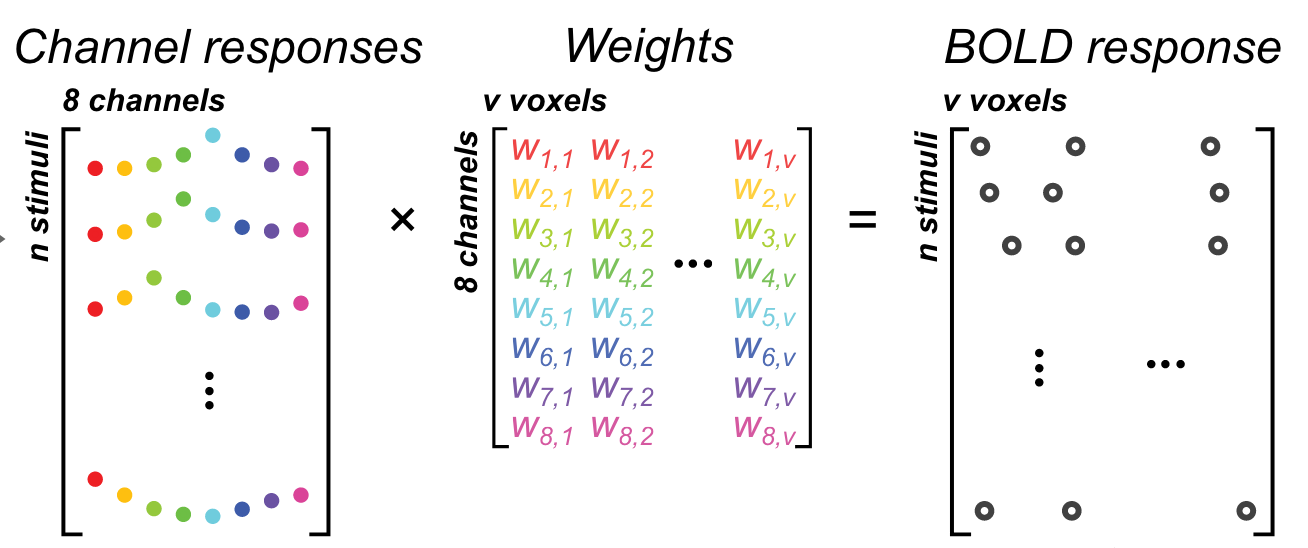

See Gardner and Liu, 2018.

$$C W = B$$

In forward encoding, we know the channel response matrix and the BOLD response matrix. So we solve for the weight matrix. For example, using the least-squares regression.

In inverse encoding, using the BOLD response matrix and an estimated weight matrix, we solve for the channel responses.


### Parts of the channel encoding model tutorial:
1. Simulating data for fitting the model.
    - Obtain channel response (C) and BOLD response (B) matrices.
2. Perform forward encoding.
    - Fitting the weight matrix to the simulated data.
    $$ W = C^\dagger B$$
    
    Question: Why calculate the pseudoinverse of a matrix?
$$C  W = B$$
$$C^\dagger C W = C^\dagger B$$
$$\mathrm(1) W = C^\dagger B$$
$$W = C^\dagger B$$
Note that $C^\dagger$ is the pseudoinverse of C.

3. Computing the goodness-of-fit. $r^2$
4. Inverting the encoding model.
    - Solving for the channel response matrix (C) using the estimated weight matrix (W).
    - Note on cross-validation. Dividing voxel response (B) in 2 parts (train and test voxel response) to test the model's ability to predict new data that was not used in estimating it.
    
    $$C = B W^\dagger$$
5. Use a simplified Bayesian algorithm to determine stimulus likelihood.
    - Stimulus likelihood function is the probability of any stimulus given a particular response. Requirements: mean response and variance around the mean response. This is obtained from the residuals once the encoding model is fitted. For example, fit a multi-variate gaussian noise model to these residuals.
    - Compute the multivariate gaussian probability distribution.
    - Note: The channel responses depend on the basis/kernel we use. In this case, we assumed them to be linear. If we assumed them to be bimodal, that is what we would obtain.

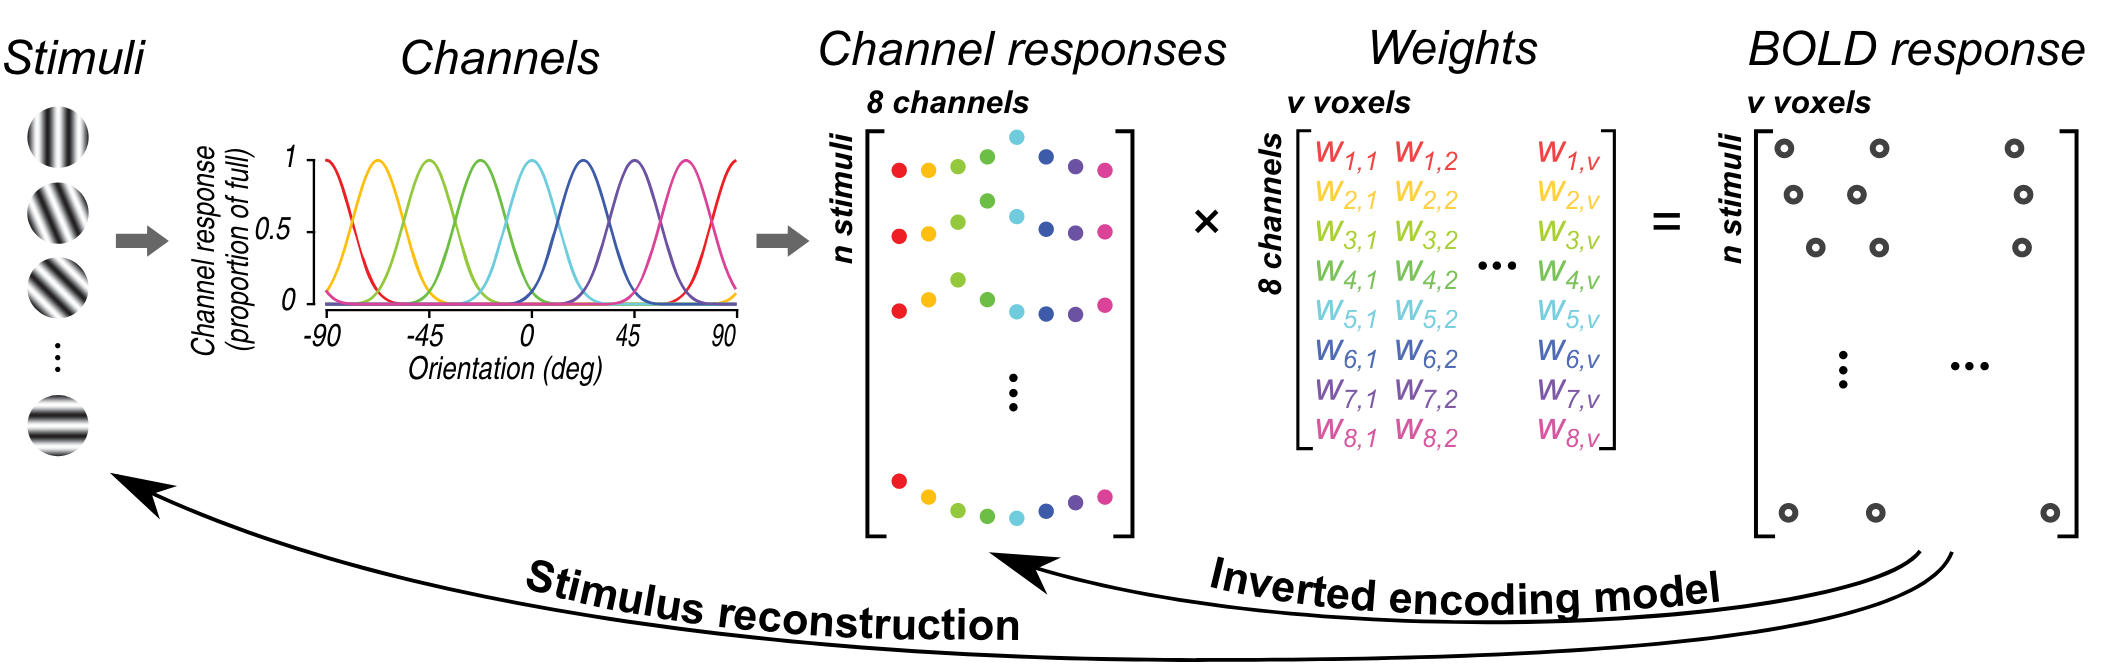
See Gardner and Liu, 2018.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd

from scipy.stats import multivariate_normal, pearsonr, ttest_ind
from scipy.optimize import curve_fit

### Create simulated stimuli, channel responses [C] and BOLD responses [B]

Tactile frequencies: 100, 130, 160, 190, 220, 250, 280, 310.

In [2]:
# Function that simulates BOLD response [B] with a gaussian function.
def simulate_data(nStimuli = 9, nRepeats = 20, nNeurons=105, sigma=10, nVoxels=50,
                  noiseStandardDeviation = 0.05):
    
    # Simulating tactile stimuli
    tactile_stimuli = [i*30+100 for i in range(nStimuli)]
    stimuli = np.asarray([[tactile_stimuli[i] for k in range(nRepeats)] for i in range(len(tactile_stimuli))]).reshape(1,nStimuli*nRepeats)
    stimuli = np.round(stimuli)
    stimuli = stimuli.astype(np.int64)

    # Simulating neural response
    neurons = np.arange(0, nNeurons)
    frequency_range = np.arange(100, 341) # Assuming there are neurons tuned from 100-309 Hz frequencied
    neuralResponse = np.zeros((len(neurons), len(frequency_range)))

    # Loop over each neuron tuning function
    for iNeuron in range(len(neurons)): # 0-90 neurons

        orientPreference = frequency_range[iNeuron*2] # 100-310 Hz in 2 Hz steps
        # Instead of a von Mises function, using a gaussian,
        # Inputs: x=orientations, mu=orientationPreference, sigma
        neuralResponse[iNeuron,:] = (1/ np.sqrt(2*np.pi*sigma**2))*np.exp(-(frequency_range-orientPreference)**2/(2*sigma**2))
        neuralResponse[iNeuron,:] = neuralResponse[iNeuron,:] / np.max(neuralResponse[iNeuron,:]) #np.abs(np.max(neuralResponse[iNeuron,:]) - np.min(neuralResponse[iNeuron,:]))
    
    # Simulated weight matrix
    neuronToVoxelWeights = np.random.rand(nNeurons, nVoxels) # Uniformly distributed random numbers

    nTrials = nStimuli * nRepeats

    # Compute the voxelResponse, B
    voxelResponse = []

    for iTrial in range(nTrials): # 20*8 = 160
        # get the neural response to this stimulus, by indexing the correct column of the neuralResponse matrix
        thisNeuralResponse = neuralResponse[:,stimuli[0][iTrial]-100] # 1-D array, 90 elements

        # multiply this by the neuronToVoxelWeights to get the voxel response on this trial.
        # Note that you need to get the matrix dimensions right, so transpose is needed on thisNeuralResponse
        voxelResponse.append(np.matmul(thisNeuralResponse.T, neuronToVoxelWeights))
    # NOTE: In one part of the code, thisNeuralResponse is transposed.
    # Question: What is the right way to think about this?
    # It doesn't matter. This is only creating the simulated BOLD response. It is not calculating anything.
    # For congruence with the Matlab code, I transposed it.
    voxelResponse = np.asarray(voxelResponse)
    
    # Scaling the reponse
    voxelResponse = voxelResponse / np.mean(voxelResponse)

    aux1, aux2 = voxelResponse.shape
    # add gaussian noise, trial-level noise.
    voxelResponse = voxelResponse + noiseStandardDeviation * np.random.randn(aux1, aux2)

    return stimuli, frequency_range, voxelResponse, neuralResponse

In [3]:
# make channel basis functions
def create_channel_basis(stimuli, nChannels = 9, exponent = 7, nStimuli = 9, nRepeats = 20):
    # Note the number of channels is the same as the number of stimuli.

    frequency_range = np.arange(100, 341)
    prefStimuli = [i*30+100 for i in range(nStimuli)] # prefOrientation

    channelBasis = np.zeros((241, nChannels)) # ideal channel responses to each of 210 frequencies
    
    # Creates the channel basis
    for iChannel in range(nChannels):
        # The output of this channel basis might be something different than expected.
        thisChannelBasis =  np.cos(2*np.pi*(frequency_range-prefStimuli[iChannel])/360)
        # rectify
        thisChannelBasis[thisChannelBasis<0] = 0
        thisChannelBasis = thisChannelBasis**exponent
        channelBasis[:,iChannel] = thisChannelBasis
        
    # Computes the channelResponse for each trial
    nTrials = nStimuli * nRepeats # 180, now 90

    channelResponse = np.zeros((nTrials, nChannels)) # 180*9, now 90*9
    
    for iTrial in range(nTrials):
        channelResponse[iTrial, :] = channelBasis[stimuli[0][iTrial]-100,:]
        
    return channelBasis, channelResponse

In [4]:
# Implementing the inverted encoding model
# Inputs: channelResponse, voxelResponse
# Outputs: estimatedWeights, modelPrediction, estimatedChannelResponse,
#          testVoxelResponse, residualResponse, r2

def model_fit_with_folds_for_ordered_stim(channelResponse, voxelResponse, nFolds=2, nConsecutiveSameTrials = 20):
    
    nTrials = channelResponse.shape[0]   

    nHalfData = int(nTrials/nFolds)
    half_nConsecutiveSameTrials = int(nConsecutiveSameTrials/2)
    first_half_vec = np.zeros(nHalfData, np.int64)
    second_half_vec = np.zeros(nHalfData, np.int64)
    index = 0

    for k in range(int(nTrials/nConsecutiveSameTrials)):
        for i in range(half_nConsecutiveSameTrials):
            first_half_vec[index] = nConsecutiveSameTrials*k + i
            second_half_vec[index] = nConsecutiveSameTrials*k + i + half_nConsecutiveSameTrials
            index += 1

    # split VoxelResponse [B] into train and test
    trainVoxelResponse = voxelResponse[first_half_vec]
    testVoxelResponse = voxelResponse[second_half_vec]
    
    # Divides channelResponse [C] into 2
    C1 = channelResponse[first_half_vec]
    C2 = channelResponse[second_half_vec]
    
    # W_estimated
    # Computes the (Moore-Penrose) pseudo-inverse of the matrix channelResponse
    estimatedWeights = np.matmul(np.linalg.pinv(C1), trainVoxelResponse)
    
    # B_predicted, compute model prediction on test data
    modelPrediction = np.matmul(C2, estimatedWeights)
    # C_estimated, compute channel response from textVoxelResponses
    estimatedChannelResponse = np.matmul(testVoxelResponse, np.linalg.pinv(estimatedWeights))
    
    # compute residual
    residualResponse = testVoxelResponse - modelPrediction
    
    # compute r2
    r2 = 1 - np.var(residualResponse) / np.var(testVoxelResponse)

    return estimatedWeights, modelPrediction, estimatedChannelResponse, trainVoxelResponse, testVoxelResponse, residualResponse, r2

In [5]:
# Function that fits some model to the noise to obtain the most likely stimulus
def recover_stim_likelihoods(channelBasis, channelResponse, testVoxelResponse,
                             residualResponse, stimuli_length, nVoxels,
                             estimatedWeights):
    
    # compute residual variance, note that this is a scalar
    residualVariance = np.var(residualResponse)

    # make this into a covariance matrix in which the diagonal contains the variance for each voxel
    # and off diagonals (in this case all 0) contain covariance between voxels
    modelCovar = np.identity(nVoxels) * residualVariance
    
    # cycle over each trial
    nTestTrials = np.size(testVoxelResponse, 0)
    likelihood = np.zeros([nTestTrials, stimuli_length])

    # WHERE WOULD YOU CONSIDER TH ENTRIES OF FREQUENCY_SPACE
#     frequency_indices = np.asarray([i for i in range(frequency_len)])
    
    for iTrial in range(nTestTrials):

    # HERE: Perhaps the error comes from here on how likelihoods are computed.
    # Either from computing the predictedResponse or from fitting a multivariate gaussian
    # to each trial
      for iStimulus in range(stimuli_length): # 211 iterations
        # compute the mean voxel response predicted by the channel encoding model
        predictedResponse = np.matmul(channelBasis[iStimulus], estimatedWeights)
        # now use that mean response and the model covariance to estimate the probability
        # of seeing this orientation given the response on this trial
        
        # HERE!! J: the predictedResponse can be expanded in the domain.
        mvnpdf = multivariate_normal.pdf(testVoxelResponse[iTrial], mean=predictedResponse,
                                         cov = modelCovar)
        likelihood[iTrial,iStimulus] = mvnpdf
        
    return likelihood

In [6]:
# Used to fit a gaussian to each trial.
def gaussian(x, mu, sigma, amplitude):
    coefficient = amplitude/ np.sqrt(2*np.pi*sigma**2)
    return coefficient*np.exp(-(x-mu)**2/(2*sigma**2))

In [7]:
# Function that given a vector, replicates the first 50 and last 50 entries of the array.
# The vector should be at least length 100
# Used as a supplementary to `curve_fit`
def mirror_edges(vector, cushion=10):
    
    length = len(vector)
    
    if length < cushion*2:
        print("Vector less than 100 entries")
        
    else:
        beginning = np.flip(vector[0:cushion])
        ending = np.flip(vector[length-cushion:length])
        
    return np.concatenate((beginning, vector, ending))

In [8]:
# Inputs nfrequencies
def gaussian_fit(probability, cushion = 10):

    # Fitting a gaussian to all the test trials
    # Trying out the mirror function to fit a gaussian to ALL the test trials.
    # xdata_real = np.asarray([float(i) for i in range(nfrequencies+25*2)])

    # Fitting a gaussian to all the test trials
    nTestTrials, nfrequencies = probability.shape

    xdata = [i-cushion for i in range(nfrequencies+cushion*2)] # 211 frequencies, 100-310
    xdata_real = [i+100-cushion for i in range(nfrequencies+cushion*2)] # 211 frequencies, 100-310

    means_vec = np.zeros(nTestTrials)
    sigmas_vec = np.zeros(nTestTrials)
    amplitudes_vec = np.zeros(nTestTrials)

    for trial_i in range(nTestTrials): # 90 iterations. THESE INDICES SHOULD SPAN THE ACTUAL SPACE
        ydata = probability[trial_i, :]
        ydata_mirror = mirror_edges(probability[trial_i,:]) # CONCATENATED VECTOR IN THE EDGES

        p0 = [probability[trial_i,:].argmax(), 0.5, 1] # initial guess

        try:
            gaussian_fit = curve_fit(gaussian, xdata, ydata_mirror, p0)
            # gaussian takes: x, mu, sigma, amplitude
        except RuntimeError:
            print("Error fitting gaussian in: ",trial_i)
            gaussian_fit = [['nan', 'nan', 'nan']]

        means_vec[trial_i], sigmas_vec[trial_i], amplitudes_vec[trial_i] = gaussian_fit[0]

    return means_vec, sigmas_vec, amplitudes_vec

# Running the simulation

In [9]:
# Initializing variables
nStimuli = 9
nRepeats = 8
nNeurons = 105
sigma = 10
nVoxels = 50

nChannels = 9 # Note how in this particular case, nStimuli = nChannels = 8
exponent = 7

noiseStandardDeviation = 0.1 # 0.4
nFolds=2
nConsecutiveSameTrials = 10

# Generating simulated data
stimuli, frequency_range, voxelResponse, neuralResponse = simulate_data(nStimuli, nRepeats, nNeurons,
                                            sigma, nVoxels, noiseStandardDeviation)

# Channel basis
channelBasis, channelResponse = create_channel_basis(stimuli, nChannels, exponent, nStimuli, nRepeats)

# Model fit with folds
# estimatedWeights, modelPrediction, estimatedChannelResponse, trainVoxelResponse, testVoxelResponse, residualResponse, r2 = model_fit_with_folds_for_ordered_stim(channelResponse, voxelResponse)
estimatedWeights, modelPrediction, estimatedChannelResponse, trainVoxelResponse, testVoxelResponse, residualResponse, r2 = model_fit_with_folds_for_ordered_stim(channelResponse, voxelResponse, nFolds, nConsecutiveSameTrials)
# Obtaining the likelihoods
nfrequencies = 241
likelihood = recover_stim_likelihoods(channelBasis, channelResponse, testVoxelResponse,
                             residualResponse, nfrequencies, nVoxels, estimatedWeights)


# Obtaining probability vector, aka normalizing likelihood across trials
trials_length, frequencies_length = likelihood.shape
probability = np.zeros([trials_length, frequencies_length])

for trial_i in range(trials_length): # 80 iterations

    upper_lim = max(likelihood[trial_i,:])
    lower_lim = min(likelihood[trial_i,:])

    # Normalization of the likelihood. It is undefined when: upper_lim = lower_lim
    probability[trial_i,:] = (likelihood[trial_i,:]-lower_lim) / (upper_lim-lower_lim)



# Fitting gaussians to all the trials 
means_vec, sigmas_vec, amplitudes_vec = gaussian_fit(probability, cushion = 10)
n_half_consecutive = int(nRepeats/2)

# Organizing the values for boxplots:
auxiliary = [i+1 for i in range(nStimuli)]
tactile_stimuli = [i*30+100 for i in range(nStimuli)]
stimuli_aux = np.asarray([[auxiliary[i] for k in range(n_half_consecutive)] for i in range(len(tactile_stimuli))]).reshape(1,round(nStimuli*nRepeats/2))

stimuli_organized = np.asarray([[tactile_stimuli[i] for k in range(n_half_consecutive)] for i in range(len(tactile_stimuli))])
means_organized = [np.asarray(means_vec[n_half_consecutive*i:n_half_consecutive*i+n_half_consecutive]+100) for i in range(nStimuli)]
sigmas_organized = [np.asarray(sigmas_vec[n_half_consecutive*i:n_half_consecutive*i+n_half_consecutive]) for i in range(nStimuli)]
amplitudes_organized = [np.asarray(amplitudes_vec[n_half_consecutive*i:n_half_consecutive*i+n_half_consecutive]) for i in range(nStimuli)]

# Measure the inverted encoding_accuracy
mean_error = np.abs(means_organized - stimuli_organized)

conditionsN, repetitionsN = mean_error.shape
average_error_per_condition = np.zeros(conditionsN)

for i in range(conditionsN):
    error_no_nans_i = mean_error[i][~np.isnan(mean_error[i])] # Removes nans
    # https://stackoverflow.com/questions/11620914/how-do-i-remove-nan-values-from-a-numpy-array
    # Note: removing nans destroys the 9*10 array structure, converting it to a big array.
    average_error_per_condition[i] = np.mean(error_no_nans_i)

# Plotting every step (shredding) the simulation.

## Simulated Voxel Response

In [10]:
# Obtain the similarity plot
nTrials = stimuli.shape[1]
matrix = np.zeros([nTrials, nTrials])

for i in range(nTrials):
    for j in range(nTrials):
        matrix[i, j] = pearsonr(voxelResponse[i,:], voxelResponse[j,:])[0]

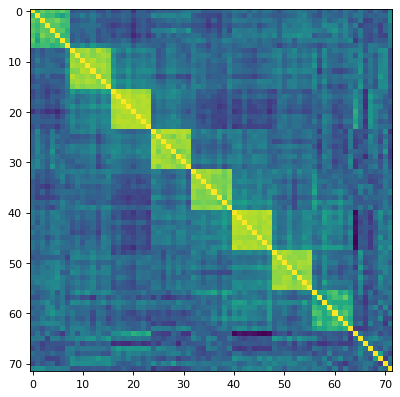

In [11]:
plt.figure(figsize=(8, 6), dpi=80)
plt.imshow(matrix)
plt.show()

## Channel Basis Functions

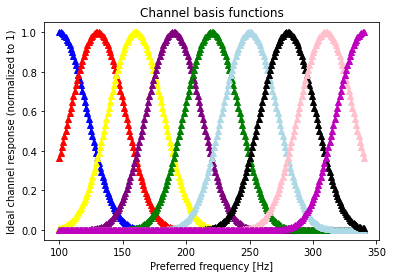

In [12]:
# Plot the mean estimatedChannelResponse for each stimulus type 
colors = ['b', 'r', 'yellow', 'purple', 'green', 'lightblue', 'k', 'pink', 'm']
# prefOrientation = [i*180/nChannels for i in range(nChannels)]

for i in range(nStimuli):
#     plt.plot(prefOrientation, means, c=colors[i], label="Preferred orientation")
    plt.plot(frequency_range, channelBasis[:,i], c=colors[i], marker="^") #, label=stimuli[0,i*10])
    
#     likelihood_means = np.mean(likelihood[vec_supplement,:], 0) # Mean across the first dimension
#     plt.plot(likelihood_means, c = colors[i], marker=".", label = "Stimulus likelihood")
    
plt.title("Channel basis functions")
plt.xlabel('Preferred frequency [Hz]')
plt.ylabel('Ideal channel response (normalized to 1)')
# plt.title("r2="+str(round(r2, 4)))
# plt.legend(bbox_to_anchor=(0.5, 0.5, 1, 0.5), title="Frequencies [Hz]")
plt.show()

## Decoding Model Accuracy and Estimated Channel Responses

In [13]:
print(r2)

0.9469894599795053


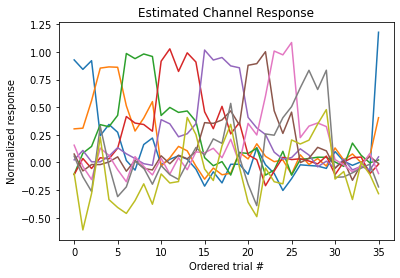

In [14]:
plt.plot(estimatedChannelResponse)
plt.xlabel('Ordered trial #')
plt.ylabel('Normalized response')
plt.title('Estimated Channel Response')
plt.show()

## Inverted Encoding Model Outputs

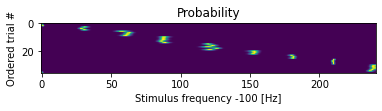

In [15]:
plt.imshow(probability)
plt.xlabel('Stimulus frequency -100 [Hz]')
plt.ylabel('Ordered trial #')
plt.title('Probability')
plt.show()

In [16]:
# Quick less than an hour exercise
# Create a function that detects peaks. How many peaks are there per condition?

def peak_detection(vec, threshold=0.1):
    
    banner = False
    peaks_i = 0
    
    for i in range(len(vec)):
        
        if vec[i] > threshold:
            if banner == False: # There is only 1 peak when the threshold is surpassed
                peaks_i +=1
                banner = True
                
        elif vec[i] < threshold and banner== True: # Resetting the banner.
            banner = False
    return peaks_i

# Fitting a gaussian to these trials

Number of peaks:  1


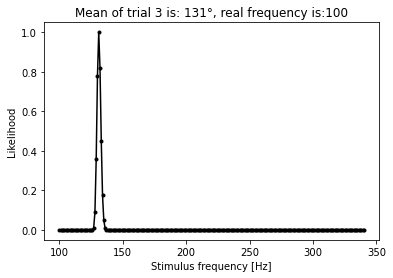

In [17]:
# Single trial, 80 possible trials
trial_i = 3
likely_stimuli = probability[trial_i,:].argmax()
all_freq_stimuli = [i+100 for i in range(241)]
print("Number of peaks: ", peak_detection(probability[trial_i,:]))

label = "Mean of trial " + str(trial_i) + " is: " + str(likely_stimuli+100) + "°, real frequency is:" + str(stimuli_organized.reshape(1, probability.shape[0])[0][trial_i])

plt.plot(all_freq_stimuli, probability[trial_i,:], marker=".", c="k")
plt.title(label)
plt.xlabel('Stimulus frequency [Hz]')
plt.ylabel('Likelihood')
plt.show()

[0.57238397 0.62974926 1.98782917]


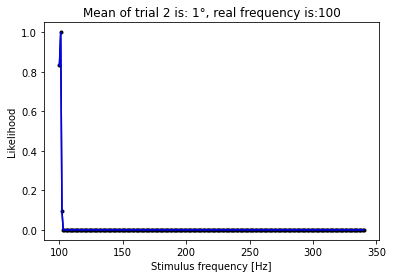

In [18]:
# Single trial
trial_i = 2

xdata = [i for i in range(241)]

ydata = probability[trial_i,:]

p0 = [probability[trial_i,:].argmax(), 0.5, 1]

# Using non-lionear least squares to fit the data
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
gaussian_fit = curve_fit(gaussian, xdata, ydata, p0)
print(gaussian_fit[0])
mean, sigma, amplitude = gaussian_fit[0]

a, b = stimuli_organized.shape

label = "Mean of trial " + str(trial_i) + " is: " + str(round(mean)) + "°, real frequency is:" + str(stimuli_organized.reshape(1, a*b)[0][trial_i])

plt.plot(all_freq_stimuli, probability[trial_i,:], marker=".", c="k")

plt.plot(all_freq_stimuli, gaussian(xdata, mean, sigma, amplitude), c="b")

plt.title(label)
plt.xlabel('Stimulus frequency [Hz]')
plt.ylabel('Likelihood')
# plt.xlim([-1,50])
# plt.xlim([150,200])
plt.show()

### What is the overall behavior of all the means and sigmas organized by stimulus frequency?

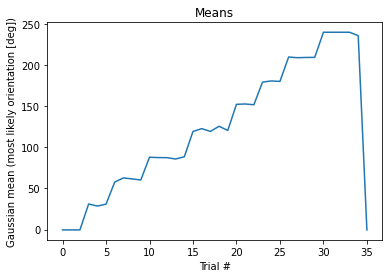

In [19]:
plt.plot(means_vec)
plt.title("Means")
plt.xlabel('Trial #')
plt.ylabel('Gaussian mean (most likely orientation [deg])')
plt.show()

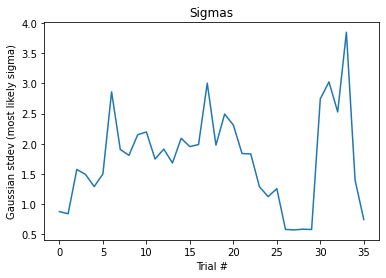

In [20]:
plt.plot(sigmas_vec)
plt.title("Sigmas")
plt.xlabel('Trial #')
plt.ylabel('Gaussian stdev (most likely sigma)')
plt.show()

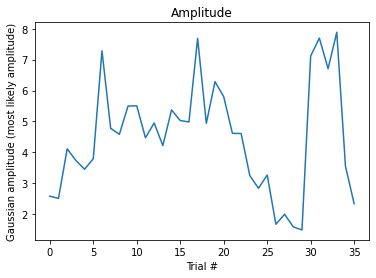

In [21]:
plt.plot(amplitudes_vec)
plt.title("Amplitude")
plt.xlabel('Trial #')
plt.ylabel('Gaussian amplitude (most likely amplitude)')
plt.show()

### Visualizing the previous data using boxplots.

In [22]:
labels = [100+i*30 for i in range(9)]

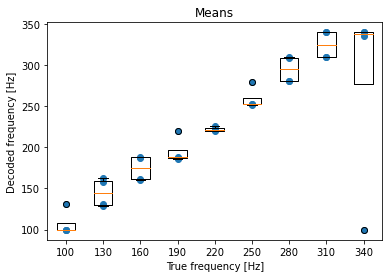

In [23]:
# The input data of the function boxplots is unintuitive.
# If a 2D array, a boxplot is drawn for each column in x.
# If a sequence of 1D arrays (list), a boxplot is drawn for each array in x.
# See documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

fig, ax = plt.subplots()

ax.boxplot(means_organized) # means_organized is a 9*10 vector
plt.scatter(stimuli_aux, means_organized) # 90-entry vector

ax.set_xticklabels(labels)

plt.xlabel(r'True frequency [Hz]')
plt.ylabel(r'Decoded frequency [Hz]')
plt.title("Means")
plt.show()

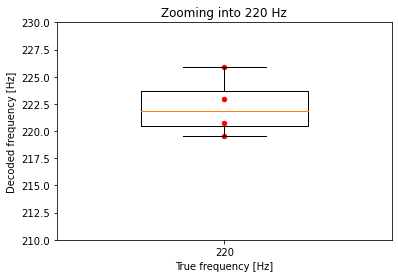

In [24]:
# Zooming into the previous plot

fig, ax = plt.subplots()

ax.boxplot(means_organized)#, notch=True, labels = stimuli_1)
plt.scatter(stimuli_aux, means_organized, s=20, c='r')

plt.ylim([210, 230])
plt.xlim([4.5, 5.5])

ax.set_xticklabels(labels)

plt.xlabel(r'True frequency [Hz]')
plt.ylabel(r'Decoded frequency [Hz]')
plt.title("Zooming into 220 Hz")
plt.show()

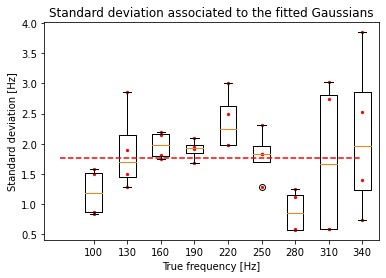

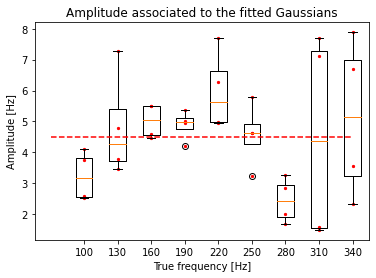

In [25]:
# The input data of the function boxplots is unintuitive.
# If a 2D array, a boxplot is drawn for each column in x.
# Igf a sequence of 1D arrays (list), a boxplot is drawn for each array in x.
# See documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

fig, ax = plt.subplots()

ax.boxplot(sigmas_organized)#, notch=True, labels = stimuli_1)
plt.scatter(stimuli_aux, sigmas_vec, s=5, c='r')
# plt.ylim([-1, 5])

plt.hlines(np.mean(sigmas_organized), 0, 9, linestyle='dashed', colors = 'r')
ax.set_xticklabels(labels)

# plt.ylim([20, 28])
# plt.xlim([1.5, 2.5])

plt.xlabel(r'True frequency [Hz]')
plt.ylabel(r'Standard deviation [Hz]')
plt.title("Standard deviation associated to the fitted Gaussians")
plt.show()

# Amplitudes
fig, ax = plt.subplots()
ax.boxplot(amplitudes_organized)#, notch=True, labels = stimuli_1)
plt.scatter(stimuli_aux, amplitudes_organized, s=5, c='r')
# plt.ylim([-1, 5])
plt.hlines(np.mean(amplitudes_organized), 0, 9, linestyle='dashed', colors = 'r')
ax.set_xticklabels(labels)

plt.xlabel(r'True frequency [Hz]')
plt.ylabel(r'Amplitude [Hz]')
plt.title("Amplitude associated to the fitted Gaussians")
plt.show()

In the 340 Hz trials, the sigmas have higher values. This might be related to the estimatedChannelResponses?

The lower sigmas for 100 and 310 Hz might be some kind of border effect?

### Plot overlay of the 10 trials for the same condition over the 9 stimulus.

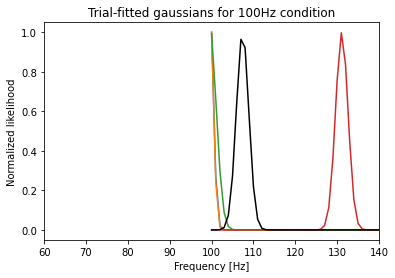

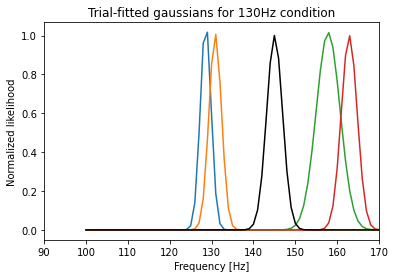

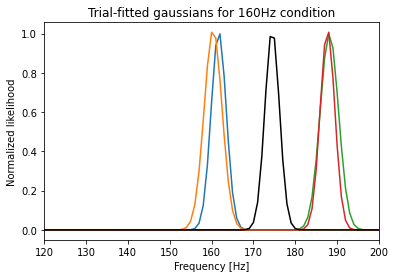

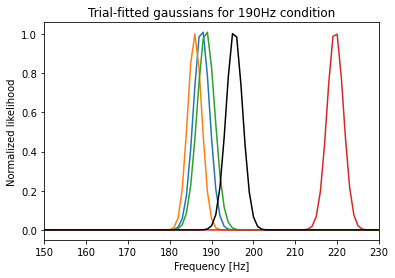

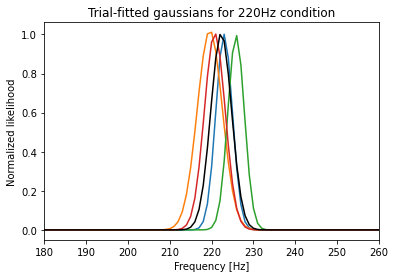

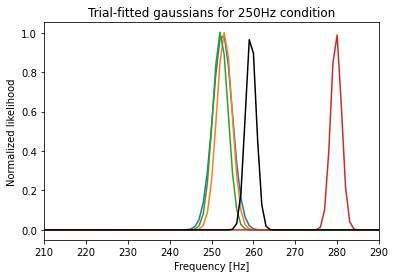

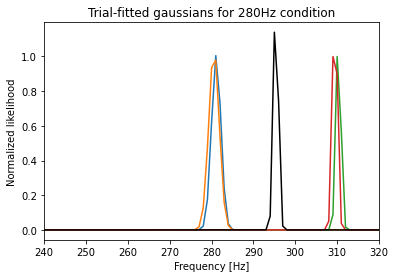

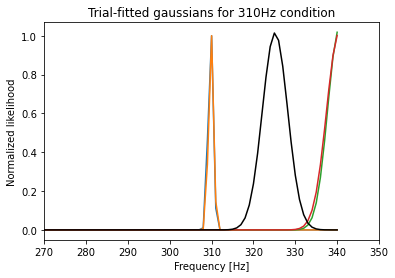

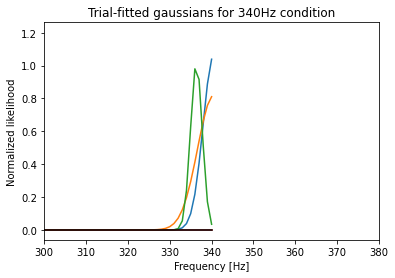

In [26]:
window = 40
for stim_i in range(len(means_organized)):
    xdata = [i+100 for i in range(nfrequencies)]
    
    mean = np.mean(means_organized[stim_i])
    sigma = np.mean(sigmas_organized[stim_i])
    amplitude = np.mean(amplitudes_organized[stim_i])
    
    for rep_i in range(len(means_organized[stim_i])):
        mean = means_organized[stim_i][rep_i]
        sigma = sigmas_organized[stim_i][rep_i]
        amplitude = amplitudes_organized[stim_i][rep_i]

        y_ind = gaussian(xdata, mean, sigma, amplitude)    
        plt.plot(xdata, y_ind)   

    yy = gaussian(xdata, np.mean(means_organized[stim_i]), sigma, amplitude)

    plt.plot(xdata, yy, c='k')
    plt.xlim([stimuli_organized[stim_i][0]-window, stimuli_organized[stim_i][0]+window])
    plt.xlabel(r'Frequency [Hz]')
    plt.ylabel(r'Normalized likelihood')
    plt.title("Trial-fitted gaussians for "+str(stimuli_organized[stim_i][0])+"Hz condition")

    plt.show()

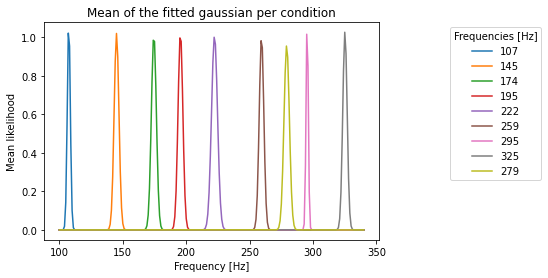

In [27]:
for stim_i in range(len(means_organized)):
    xdata = [i+100 for i in range(nfrequencies)]
    
    mean = np.mean(means_organized[stim_i])
    sigma = np.mean(sigmas_organized[stim_i])
    amplitude = np.mean(amplitudes_organized[stim_i])

    yy = gaussian(xdata, np.mean(means_organized[stim_i]), sigma, amplitude)
    
    label_Hz = str(round(mean))
    plt.plot(xdata, yy, label=label_Hz)
    
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Mean likelihood')    
plt.title("Mean of the fitted gaussian per condition")
plt.legend(bbox_to_anchor=(0.5, 0.5, 1, 0.5), title="Frequencies [Hz]")
# plt.legend()
plt.show()

### When does the model break?
### Calculating the error of the fitted gaussian's mean compared to the real frequency.
### Inverted decoding accuracy
### Calculating the error per condition.

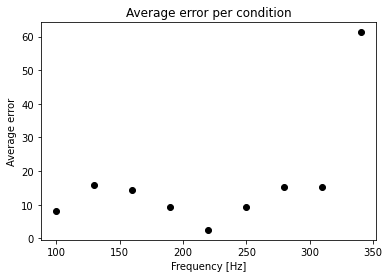

In [28]:
plt.scatter(tactile_stimuli, average_error_per_condition, c="k")#, label=label_Hz)
    
plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Average error')    
plt.title("Average error per condition")
# plt.legend(bbox_to_anchor=(0.5, 0.5, 1, 0.5), title="Frequencies [Hz]")
# plt.legend()
plt.show()

Collapsing across conditions, that is, first obtaining the average per condition and then averaging across conditions. Note this might give other results if we first remove nans, flatten the array and average across all trials.

In [29]:
np.mean(average_error_per_condition)

16.84441550350467

# Bugs during the last week of August:
- The average of a vector with NaNs is always NaN.
- GAUSSIANS ARE TRANSLATED BY 100 IN THE X ACIS. THE ORIGINAL SPACE IS NOT 0-240. IT IS 100-340 HZ!! Consequence: Negative amplitudes.

Note `means_organized` are in the space of 100-340 Hz.

## Copied and pasted from the Distributions_and_false_positives notebook

## Statistics

Two sample test:

$$t = \frac{\vec{X}_1 - \vec{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

### Note this test is not invariant under a linear transformation! So if we fit an amplitude term to the gaussian, we will obtain different t values!!

In [30]:
# stimuli_1 = [i*30+100 for i in range(nStimuli)]
# stimuli_short = stimuli_1[1:7] # Taking out the elements in the boundaries

In [31]:
# # Perform two-sample t-test

# # for i in range(len(stimuli_1)):
# #     for k in range(i, len(stimuli_1)):
# #         t_statistic, p_value = ttest_ind(sigmas_organized[i], sigmas_organized[k])
# #         if p_value < 0.05:
# #             print("There is a statistical difference between:", stimuli_1[i]," and ", stimuli_1[k])
            
            
# # Perform two-sample t-test
# false_positives_counter = 0
# counter = 0
# for i in range(len(stimuli_short)):
#     for k in range(i, len(stimuli_short)):
#         t_statistic, p_value = ttest_ind(sigmas_organized[i], sigmas_organized[k])
#         counter +=1
#         if p_value < 0.05:
#             print("p=",p_value,". Statistical difference between:", stimuli_1[i]," and ", stimuli_1[k])
#             false_positives_counter += 1
# print(false_positives_counter/counter)

Naïvely, I think there should be no statistical difference in the data since it all comes from the same kind of sampling of the same artificial neurons. But maybe if there is a statistical difference it is because a small $n$.

In [32]:
# # The input data of the function boxplots is unintuitive.
# # If a 2D array, a boxplot is drawn for each column in x.
# # Igf a sequence of 1D arrays (list), a boxplot is drawn for each array in x.
# # See documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

# fig, ax = plt.subplots()
# ax.boxplot(sigmas_organized)#, notch=True, labels = stimuli_1)
# # plt.scatter(stimuli_1, means_organized)
# plt.scatter(stimuli_aux, sigmas_vec, s=5, c='r')
# # plt.scatter(stimuli_test, means_vec, s=5)
# # plt.ylim([-1, 5])
# plt.hlines(np.mean(sigmas_organized[1:7]), 0, 9, linestyle='dashed', colors = 'r')

# # Tick label https://stackoverflow.com/questions/11244514/modify-tick-label-text
# # labels = [item.get_text() for item in ax.get_xticklabels()]
# labels = [int(stimuli_1[i]) for i in range(len(stimuli_1))]
# ax.set_xticklabels(labels)

# plt.xlabel(r'True frequency [Hz]')
# plt.ylabel(r'Standard deviation [Hz]')
# plt.title("Standard deviation associated to the fitted Gaussians")
# plt.show()

In [33]:
# # The input data of the function boxplots is unintuitive.
# # If a 2D array, a boxplot is drawn for each column in x.
# # Igf a sequence of 1D arrays (list), a boxplot is drawn for each array in x.
# # See documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

# fig, ax = plt.subplots()

# ax.boxplot(amplitudes_organized)#, notch=True, labels = stimuli_1)
# # plt.scatter(stimuli_1, means_organized)
# plt.scatter(stimuli_aux, amplitudes_vec, s=5, c='r')
# # plt.scatter(stimuli_test, means_vec, s=5)
# # plt.ylim([-1, 5])

# plt.hlines(np.mean(amplitudes_organized[1:7]), 0, 9, linestyle='dashed', colors = 'r')

# # plt.ylim([20, 28])
# # plt.xlim([1.5, 2.5])

# # Tick label https://stackoverflow.com/questions/11244514/modify-tick-label-text
# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels = [int(stimuli_1[i]) for i in range(len(stimuli_1))]
# ax.set_xticklabels(labels)

# plt.xlabel(r'True $\theta$ [deg]')
# plt.ylabel(r'Fitted amplitude')
# plt.title("Amplitudes associated to the fitted Gaussians")
# plt.show()

## Note how the amplitudes have the same trend as the standard deviations. But, the y scale is different.

In [34]:
# # Perform two-sample t-test
# # This loop should only be the upper traingle or lower one of the matrix.
# # Right now it is doing more than 2 times the necessary computations.

# for i in range(len(stimuli_1)):
#     for k in range(i, len(stimuli_1)):
#         t_statistic, p_value = ttest_ind(amplitudes_organized[i], amplitudes_organized[k])
#         if p_value < 0.05:
#             print("There is a statistical difference between:", stimuli_1[i]," and ", stimuli_1[k])
# # print(t_statistic)
# # print(p_value)